In [118]:
import pandas as pd
import sqlite3
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import plotly.express as px
import numpy as np
import datetime
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import folium
import xgboost as xgb
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

In [119]:
def create_date_faetures(df):
    """
    creates data features from YEAR and DOY.
    create a new column of date which is calculated from FIRE_YEAR and DISCOVERY_DOY, and extract from there features
    :param df: data
    :return: a new dataframe containing only the features we added
    """
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

    features = pd.DataFrame()
    df["DISCOVERY_DATE"] = pd.to_datetime(df['FIRE_YEAR'] * 1000 + df['DISCOVERY_DOY'], format='%Y%j')
    cal = calendar()

    # is holiday feature
    holidays = cal.holidays(start=df["DISCOVERY_DATE"].min(), end=df["DISCOVERY_DATE"].max())
    features['IS_HOLIDAY'] = df['DISCOVERY_DATE'].isin(holidays).astype(int)

    # is fourth of july feature
    features['IS_4TH_JULY'] = df['DISCOVERY_DATE'].apply(lambda date: 1 if date.strftime("%B %d") == "July 04" else 0)

    # is weekend feature
    features['IS_WEEKEND'] = dayofweek = df["DISCOVERY_DATE"].dt.dayofweek
    features['IS_WEEKEND'][dayofweek >= 5] = 1
    features['IS_WEEKEND'][dayofweek < 5]  = 0

    features["WEST_TO_10W"] = np.where(df['LONGITUDE'] >= -100, 1, 0)

    # month dummies
    month_dummies = pd.get_dummies(df["DISCOVERY_DATE"].dt.month, prefix="MONTH", drop_first=True)
    features = pd.concat([features, month_dummies], axis=1)

    return features



In [120]:
def pre_process_data(data):
    features = create_date_faetures(data)
    data = data.merge(features, left_index=True, right_index=True)

    # One-Hot Encoding
    for f in ['STATE', 'FIRE_YEAR']: # add months
        data = pd.get_dummies(data,prefix=[f], columns = [f], drop_first=True)

    # Ordinal Encoding
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    le.fit(data['FIRE_SIZE_CLASS'])
    data['FIRE_SIZE_CLASS'] = le.transform(data['FIRE_SIZE_CLASS']) + 1

    def is_south_east_state(df):
        return df["STATE_FL"]+df["STATE_AL"]+df["STATE_GA"]+df["STATE_SC"]+df["STATE_MS"]+df["STATE_TN"]+df["STATE_NC"]

    data["IS_SOUTH_EAST"] = np.where(is_south_east_state(data) == 1, 1, 0)

    columns_to_drop = ['OBJECTID', 'FOD_ID', 'FPA_ID', 'NWCG_REPORTING_UNIT_ID',
               'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
               'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME', 'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME','COMPLEX_NAME', 'OWNER_CODE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', "Shape", "DISCOVERY_TIME", "CONT_TIME",
               "OWNER_DESCR", "DISCOVERY_DATE", "DISCOVERY_DOY", "CONT_DOY", "CONT_DATE", "FIRE_SIZE",
                "SOURCE_SYSTEM", "SOURCE_SYSTEM_TYPE", "NWCG_REPORTING_AGENCY", "STAT_CAUSE_DESCR"]

    data = data.drop(columns = columns_to_drop)

    return data



In [121]:
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
raw_df = pd.read_sql_query("SELECT * from Fires", conn)
raw_df["STAT_CAUSE_CODE"] = raw_df["STAT_CAUSE_CODE"].astype(int)
X, y = raw_df.drop(columns = ["STAT_CAUSE_CODE"]), raw_df.filter(items = ["STAT_CAUSE_CODE"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
df = X_train.merge(y_train, left_index=True, right_index=True)
X_train = pre_process_data(X_train)
X_test = pre_process_data(X_test)

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_7856\2807412305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['IS_WEEKEND'][dayofweek >= 5] = 1
C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_7856\2807412305.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['IS_WEEKEND'][dayofweek < 5]  = 0
C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_7856\2807412305.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [146]:
income_df = pd.read_csv("kaggle_income.csv", encoding="latin1").drop_duplicates(subset=['Lat', "Lon"])
income_locations = [(row["Lat"], row["Lon"]) for _, row in income_df.iterrows()]

In [149]:
def create_index(locations):
    index = rtree.index.Index()
    for i, location in enumerate(locations):
        index.insert(i, location)
    return index

index = create_index(income_locations)
def add_income_features(df):

    def find_closest_location(target_row):
        target_location = (target_row["LATITUDE"], target_row["LONGITUDE"])
        closest_location = None
        closest_distance = float("inf")
        for i in index.nearest(target_location, 1):
            location = income_locations[i]
            distance = haversine.haversine(location, target_location)
            if distance < closest_distance:
                closest_location = location
                closest_distance = distance
        return closest_location

    df["closest_location"] = df.apply(find_closest_location, axis=1)

    df[['Lat', 'Lon']] = df["closest_location"].apply(lambda x: pd.Series(x))
    df = pd.merge(df, income_df, on=['Lat', 'Lon'], how="left")
    df = df.drop(columns = ['id', 'State_Code', 'State_Name', 'State_ab', 'Zip_Code', 'Area_Code', 'Lat', "Lon", 'closest_location'])
    return df

In [151]:
X_train = add_income_features(X_train)
X_test = add_income_features(X_test)

In [152]:
def encode_income_columns(data):
    # One-Hot Encoding
    for f in ['Type', 'Primary']:
        data = pd.get_dummies(data,prefix=[f], columns = [f], drop_first=True)

    # Ordinal Encoding
    le = preprocessing.LabelEncoder()
    for c in ['County', 'City', 'Place']:
        le.fit(data[c])
        data[c] = le.transform(data[c]) + 1

    return data

In [153]:
X_train = encode_income_columns(X_train)
X_test = encode_income_columns(X_test)

C:\Users\t-tomerfried\AppData\Local\Temp\ipykernel_7856\2176064931.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(random_state=10).fit(X_train, y_train)


Random Forest accuracy score is:
0.548638852373234
Random Forest F1 score is:
              precision    recall  f1-score   support

           1       0.69      0.80      0.75     23271
           2       0.36      0.24      0.29     12469
           3       0.20      0.06      0.09      4428
           4       0.43      0.25      0.31      6387
           5       0.50      0.67      0.57     35799
           6       0.46      0.39      0.42      2753
           7       0.54      0.50      0.52     23178
           8       0.30      0.13      0.18      5139
           9       0.48      0.50      0.49     26972
          10       0.54      0.35      0.42       994
          11       0.20      0.05      0.08      1177
          12       0.14      0.03      0.05       310
          13       0.85      0.79      0.82     13829

    accuracy                           0.55    156706
   macro avg       0.44      0.37      0.38    156706
weighted avg       0.53      0.55      0.53    156706



[('LONGITUDE', 0.146572060352407),
 ('LATITUDE', 0.13134858680010555),
 ('ALand', 0.04462976320251348),
 ('Mean', 0.035339489872349826),
 ('sum_w', 0.0350839214399272),
 ('Stdev', 0.0348371201752245),
 ('Median', 0.03389865943002417),
 ('City', 0.033854930252357224),
 ('AWater', 0.03299897151909043),
 ('FIRE_SIZE_CLASS', 0.03207275654280039),
 ('IS_WEEKEND', 0.025398853827110178),
 ('County', 0.01682094280227828),
 ('Place', 0.016503720213953924),
 ('WEST_TO_10W', 0.012119075622344003),
 ('MONTH_8', 0.011537342666565656),
 ('MONTH_7', 0.011372850805119024),
 ('MONTH_4', 0.01065857732834121),
 ('FIRE_YEAR_2007', 0.010626919468549514),
 ('FIRE_YEAR_2011', 0.01060157770310437),
 ('FIRE_YEAR_2008', 0.010040320890267072),
 ('MONTH_6', 0.0099317782699569),
 ('FIRE_YEAR_2006', 0.009927353588647981),
 ('MONTH_3', 0.0095216338974858),
 ('MONTH_5', 0.009438270544347283),
 ('FIRE_YEAR_2009', 0.00917799590482711),
 ('FIRE_YEAR_2005', 0.00914711669048452),
 ('FIRE_YEAR_2010', 0.0091348206766611),
 

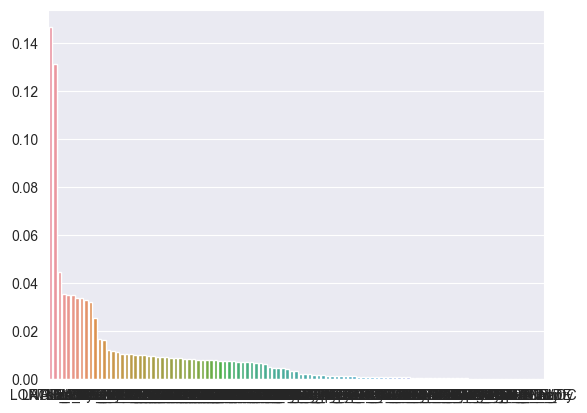

In [154]:
rf = RandomForestClassifier(random_state=10).fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print("Random Forest accuracy score is:")
print(accuracy_score(y_test,rf_preds))
print("Random Forest F1 score is:")
print(classification_report(y_test,rf_preds, zero_division=0))

feature_importances = sorted(list(zip(X_train.columns, rf.feature_importances_)), key=lambda x: -x[1])
columns = list(list(zip(*feature_importances))[0])
importances = list(list(zip(*feature_importances))[1])
sns.barplot(x=columns, y=importances)
feature_importances

In [156]:
list(X_train.columns)

['FIRE_SIZE_CLASS',
 'LATITUDE',
 'LONGITUDE',
 'IS_HOLIDAY',
 'IS_4TH_JULY',
 'IS_WEEKEND',
 'WEST_TO_10W',
 'MONTH_2',
 'MONTH_3',
 'MONTH_4',
 'MONTH_5',
 'MONTH_6',
 'MONTH_7',
 'MONTH_8',
 'MONTH_9',
 'MONTH_10',
 'MONTH_11',
 'MONTH_12',
 'STATE_AL',
 'STATE_AR',
 'STATE_AZ',
 'STATE_CA',
 'STATE_CO',
 'STATE_CT',
 'STATE_DC',
 'STATE_DE',
 'STATE_FL',
 'STATE_GA',
 'STATE_HI',
 'STATE_IA',
 'STATE_ID',
 'STATE_IL',
 'STATE_IN',
 'STATE_KS',
 'STATE_KY',
 'STATE_LA',
 'STATE_MA',
 'STATE_MD',
 'STATE_ME',
 'STATE_MI',
 'STATE_MN',
 'STATE_MO',
 'STATE_MS',
 'STATE_MT',
 'STATE_NC',
 'STATE_ND',
 'STATE_NE',
 'STATE_NH',
 'STATE_NJ',
 'STATE_NM',
 'STATE_NV',
 'STATE_NY',
 'STATE_OH',
 'STATE_OK',
 'STATE_OR',
 'STATE_PA',
 'STATE_PR',
 'STATE_RI',
 'STATE_SC',
 'STATE_SD',
 'STATE_TN',
 'STATE_TX',
 'STATE_UT',
 'STATE_VA',
 'STATE_VT',
 'STATE_WA',
 'STATE_WI',
 'STATE_WV',
 'STATE_WY',
 'FIRE_YEAR_1993',
 'FIRE_YEAR_1994',
 'FIRE_YEAR_1995',
 'FIRE_YEAR_1996',
 'FIRE_YEAR_1997'